In [58]:
import numpy as np
from matplotlib import pyplot as plt

In [59]:
def show_maze(maze, path=None):
    if path is None:
        path = np.copy(maze)
        path.fill(False)

    path_masked = np.ma.masked_array(path, maze)
    maze_masked = np.ma.masked_array(maze, path)

    fig, ax = plt.subplots()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(path_masked, cmap='Reds', vmin=0, vmax=1)
    ax.imshow(maze_masked, cmap='binary', vmin=0, vmax=1)
    plt.show()

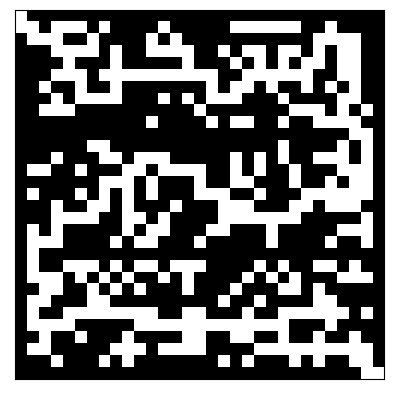

In [60]:
data = np.loadtxt("data/maze_5.csv", delimiter=",", dtype=bool)
n = len(data)
show_maze(data)

In [61]:
def dijkstra(maze):
    end = len(maze) - 1
    reacheable = []
    previous_step_info = [((0,0), (0, 0))]
    previous_step = [(0, 0)]
    steps = []

    while True:
        steps.append(previous_step_info)
        tmp_info = []
        tmp = []

        for point in previous_step:
            reacheable.append(point)
            where = [(-1, 0), (0, 1), (0, -1), (1, 0)]
            if point[0] == 0:
                where.remove((-1, 0))
            if point[1] == 0:
                where.remove((0, -1))
            if point[0] == end:
                where.remove((1, 0))
            if point[1] == end:
                where.remove((0, 1))

            for to in where:
                p = (point[0] + to[0], point[1] + to[1])

                if not maze[p[0]][p[1]] and not (p in reacheable or p in previous_step or p in tmp):
                    tmp_info.append(tuple([point, p]))
                    tmp.append(p)

                if p == (end, end):
                    steps.append(tmp_info)
                    return steps
                
        if(len(tmp) == 0):
           return steps
        
        previous_step_info = tmp_info
        previous_step = tmp

In [62]:
def get_path(steps):
    i = len(steps) - 1
    path = [(len(data) - 1, len(data) - 1)]
    while ((0, 0), (0, 0)) not in steps[i]:
        for info in steps[i]:
            if path[-1] in info:
                path.append(info[0])
                i -= 1
                break
    return path

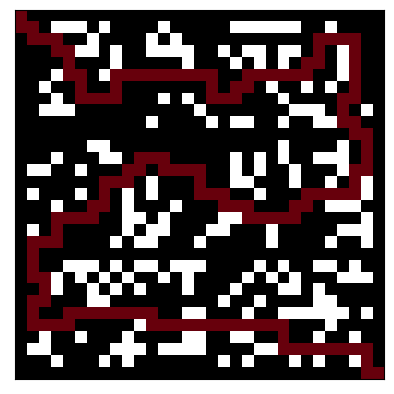

In [63]:
steps = dijkstra(data)
path = get_path(steps)
path_maze = np.ndarray(shape=[len(data), len(data)], dtype=bool)
path_maze.fill(False)
for point in path:
    path_maze[point[0]][point[1]] = True

show_maze(data, path_maze)

prochazime bludiste a hrany grafu postupne pridavame do incidenční matice

In [64]:
def genarate_incendence(maze):
    incendence = [np.array([False for i in range(n**2)])]
    end = len(maze) - 1
    reacheable = []
    previous_step_info = [((0,0), (0, 0))]
    previous_step = [(0, 0)]
    steps = []

    while True:
        steps.append(previous_step_info)
        tmp_info = []
        tmp = []

        for point in previous_step:
            reacheable.append(point)
            where = [(-1, 0), (0, 1), (0, -1), (1, 0)]
            if point[0] == 0:
                where.remove((-1, 0))
            if point[1] == 0:
                where.remove((0, -1))
            if point[0] == end:
                where.remove((1, 0))
            if point[1] == end:
                where.remove((0, 1))

            for to in where:
                p = (point[0] + to[0], point[1] + to[1])

                if not maze[p[0]][p[1]] and not (p in reacheable or p in previous_step or p in tmp):
                    tmp_info.append(tuple([point, p]))
                    tmp.append(p)

                    edge = [np.array([False for i in range(n**2)])]
                    edge[0][p[0] * n + p[1]] = True
                    edge[0][(point[0]) * n + point[1]] = True
                    incendence = np.append(incendence, edge, axis=0)


                if p == (end, end):
                    steps.append(tmp_info)
                                    
        if(len(tmp) == 0):
            incendence = np.delete(incendence, 0, axis=0)
            return incendence
        
        previous_step_info = tmp_info
        previous_step = tmp

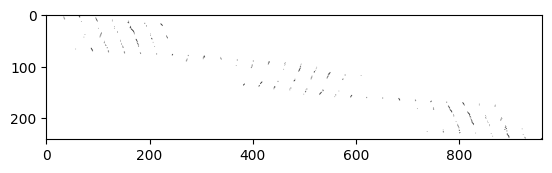

In [65]:
incend = genarate_incendence(data)
#print(incend)
fig, ax = plt.subplots()
ax.imshow(incend, cmap='binary')
plt.show()

In [66]:
def generate_maze(incendence):
    n = int(len(incendence[0])**0.5)
    maze = np.ndarray(shape=[n, n], dtype=bool)
    maze.fill(True)
    for edge in incendence:
        id = np.where(edge == True)[0]
        for i in id:
            x = i // n
            y = i % n
            maze[x][y] = False
    return maze

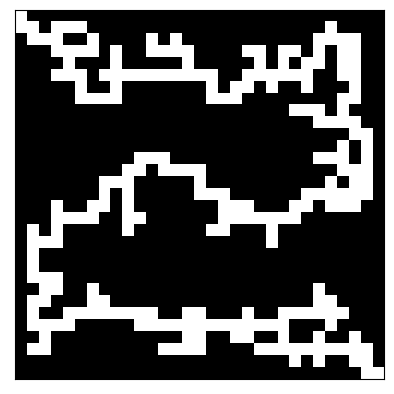

In [67]:
m = generate_maze(incend)
show_maze(m)